In [1]:
"""
This programs calculates topic scores for each news,aggregate on a daily basis
I do not assigne names at the moment
Calculate the entropy and plot with the topics Fig5
Fig 6 is generated by plotting the relevant topics
25 May 2021

Author: Yuting Chen
"""


import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore

# spacy for lemmatization
import spacy

# Plotting toolsw
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

from gensim.test.utils import datapath
import gensim.models.ldamodel

C:\ProgramData\Anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:164: DeprecationWarning: `np.float` is a de

In [4]:
%%time
# load processed file
df = pd.read_pickle('news_Processed.pkl')
# df = pd.read_pickle('history_Processed.pkl') # for economic narratives
df = df[['date','corpus']]
df

Wall time: 1min 44s


date                                             corpus
0      2020-01-10  [(0, 1), (1, 5), (2, 1), (3, 2), (4, 1), (5, 1...
1      2020-01-10  [(0, 1), (1, 5), (2, 1), (3, 2), (4, 1), (5, 1...
2      2020-01-10  [(0, 1), (1, 5), (2, 1), (3, 2), (4, 1), (5, 1...
3      2020-01-12  [(1, 4), (3, 2), (8, 1), (16, 2), (37, 1), (40...
4      2020-01-20  [(11, 1), (15, 1), (29, 1), (41, 1), (47, 5), ...
...           ...                                                ...
159967 2021-04-24  [(3, 1), (9, 2), (15, 1), (24, 1), (33, 1), (3...
159968 2021-04-24  [(15, 1), (19, 1), (30, 1), (36, 1), (41, 1), ...
159969 2021-04-24  [(13, 1), (15, 1), (36, 1), (43, 1), (52, 1), ...
159970 2021-04-24  [(15, 1), (30, 1), (38, 2), (41, 1), (123, 1),...
159971 2021-04-24  [(63, 1), (66, 1), (111, 1), (118, 1), (138, 2...

[159972 rows x 2 columns]

In [13]:
%%time
# 4h 10min 27s
"""loop and load the trained models"""
# the same setting I used in the training
start = 20
limit = 30
step = 10

df_ts = []

for i in range(start, limit, step):
    k = i
    print("k = ",str(k))
    model_name = select_path()+"Temp/LDA/"+"model_" + test_type + "_"+str(k)
    lda = LdaMulticore.load(model_name)
    
    pprint(lda.print_topics(num_topics = k, num_words=20))
    print("\n\n")

    # Calculating the topic scores in each news, save them to different columns
    topics = {}
    for i in range(k):
        t_name = "topic"+str(i+1)
        topics[t_name]=[]

    scores = lda[df['corpus']]

    for i in scores:
    #     print(i)
        list_index = []
        for index,score in sorted(i):
            t_name = "topic"+str(index+1)
            topics[t_name].append(score)
            list_index.append(index)
        # fill the topics with no probability with nan
        for j in [x for x in list(range(k)) if x not in list_index]:
            t_name = "topic"+str(j+1)
            topics[t_name].append(0)
    
    df_t = df.copy()
    df_t = df_t.drop(columns=['corpus'])
    for topic,scores in topics.items():
        df_t[topic] = scores

    df_ts.append(df_t)
    
    print(df_t.shape)

k =  20
[(0,
  '0.011*"company" + 0.010*"percent" + 0.009*"million" + 0.009*"production" + '
  '0.007*"gold" + 0.007*"price" + 0.007*"include" + 0.007*"increase" + '
  '0.006*"result" + 0.006*"cost" + 0.006*"project" + 0.005*"per" + '
  '0.005*"expect" + 0.005*"financial" + 0.005*"mine" + 0.005*"operation" + '
  '0.005*"statement" + 0.004*"information" + 0.004*"total" + '
  '0.004*"forward_looke"'),
 (1,
  '0.014*"eu" + 0.009*"government" + 0.008*"deal" + 0.008*"would" + '
  '0.007*"country" + 0.006*"minister" + 0.006*"prime_minister" + 0.006*"party" '
  '+ 0.006*"european" + 0.005*"election" + 0.005*"new" + 0.004*"leader" + '
  '0.004*"europe" + 0.004*"agreement" + 0.004*"economic" + 0.004*"state" + '
  '0.004*"vote" + 0.004*"pandemic" + 0.004*"political" + 0.004*"meeting"'),
 (2,
  '0.023*"government" + 0.011*"budget" + 0.010*"would" + 0.008*"covid" + '
  '0.008*"support" + 0.007*"federal" + 0.006*"billion" + 0.006*"work" + '
  '0.006*"state" + 0.006*"need" + 0.006*"job" + 0.006*"can

<AxesSubplot:xlabel='date'>

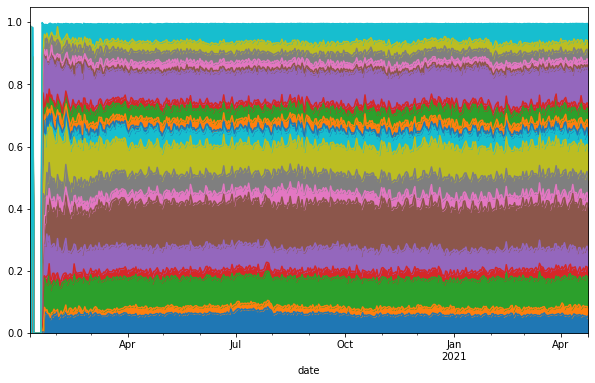

In [11]:
"""I have the topic distribution files ready in LDA2_application_a_comparison, I can directly import here"""
#comment the codes below if start from here
# for i in range(0,len(range(start, limit, step))):
#     print(i)
#     df_t = df_ts[i]
#     k = range(start, limit, step)[i]
#     # save the topic distributions
#     dfname = select_path()+"Temp/LDA/"+"topic_distribution_"+data_type+"_data_"+test_type+str(k)+"_model"+".pkl"
#     df_t.to_pickle(dfname)

# because I am only interested in one model, I can load the one directly since the second time
k=20
df_t = pd.read_pickle(select_path()+"Temp/LDA/"+"topic_distribution_"+data_type+"_data_"+test_type+str(k)+"_model"+".pkl")
df_t = df_t.set_index('date')
df_t = df_t.resample('D').mean()
df_t.plot.area(stacked=True,figsize=(10,6),legend=False)

In [12]:
# calculate the shannon entropy
from scipy.stats import entropy

Wall time: 310 ms


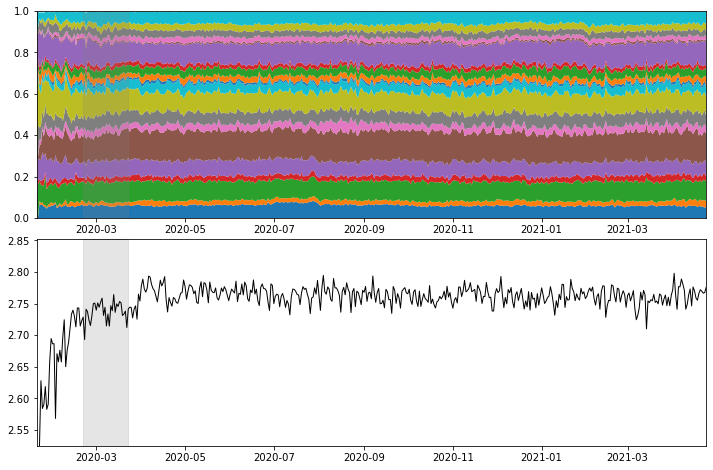

In [14]:
%%time
df_entropy = pd.DataFrame()
# s_date = pd.to_datetime('2019-9-01')
# e_date = pd.to_datetime('2020-12-31')
# df_t = df_t[s_date:e_date]
df_entropy['date'] = df_t.index


fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12,8))
fig.subplots_adjust(hspace=0.1)

# axes.flatten()[0].plot(dates,ydata, 'o', label="True I",markersize=1.5)
from datetime import datetime
crashstart = datetime(2020, 2, 21) 
crashend = datetime(2020, 3, 23)

axes.flatten()[0].stackplot(df_t.index, *np.asarray(df_t).T)
axes.flatten()[0].axis(ymin=0,ymax=1,xmin = df_t.index[10],xmax = df_t.index[-1])
axes.flatten()[0].axvspan(crashstart, crashend, alpha=0.2, color='grey')

axes.flatten()[1].plot(df_t.index,entropy(np.asarray(df_t).T), 
                       label = "Shannon Entropy",color = 'black',linewidth=1)
axes.flatten()[1].axis(ymin = 2.525, xmin = df_t.index[10],xmax = df_t.index[-1])
axes.flatten()[1].axvspan(crashstart, crashend, alpha=0.2, color='grey')

path_output = select_path()+"Output/"

fig.savefig("LDA_Entropy_economictopics.png")


In [ ]:
# plot some topic series, for coronavirus narratives only
# maybe I don't need this figure
if data_type == 'news' and k == 20:
    fig, ax = plt.subplots(figsize=(12, 6))

    # Add x-axis and y-axis
    ax.plot(df_t.index.values,df_t['topic2'],label="vaccine",linewidth=1)
    ax.plot(df_t.index.values,df_t['topic10'],label="covid updates",linewidth=1)

    plt.legend()

    # Set title and labels for axes
    ax.set(xlabel="Date",
           ylabel='Narrative Intensity')
    ax.axis(ymax = 0.15)
    plt.show()
    fig.savefig('narrative_intensity_covid.png',bbox_inches=None)